# Algorithms for Big Data - Exercise 8
This lecture is focused on the more advanced examples of the RNN usage for text generation.

We will use Harry Potter books in this lectures for generating our own stories.

You can download the dataset from this course [Github](https://github.com/rasvob/2020-21-ARD/tree/master/datasets)


In [1]:
def add_logger(path='log.txt'):
    nblog = open(path, "a+")
    sys.stdout.echo = nblog
    sys.stderr.echo = nblog

    get_ipython().log.handlers[0].stream = nblog
    get_ipython().log.setLevel(logging.INFO)

[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_08.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_08.ipynb)

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow as tf
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.8.0'

In [5]:
import unicodedata, re, string
import nltk
from textblob import TextBlob

In [6]:
import requests
from typing import List, Tuple

In [7]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/usp/pro0255/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# We need to download the data first and split text to lines

In [9]:
req = requests.get('https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/datasets/hp1.txt', allow_redirects=True)

In [10]:
txt = str(req.text).splitlines()

In [11]:
txt[:20]

["Harry Potter and the Sorcerer's Stone",
 '',
 '',
 'CHAPTER ONE',
 '',
 'THE BOY WHO LIVED',
 '',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say',
 'that they were perfectly normal, thank you very much. They were the last',
 "people you'd expect to be involved in anything strange or mysterious,",
 "because they just didn't hold with such nonsense.",
 '',
 'Mr. Dursley was the director of a firm called Grunnings, which made',
 'drills. He was a big, beefy man with hardly any neck, although he did',
 'have a very large mustache. Mrs. Dursley was thin and blonde and had',
 'nearly twice the usual amount of neck, which came in very useful as she',
 'spent so much of her time craning over garden fences, spying on the',
 'neighbors. The Dursleys had a small son called Dudley and in their',
 'opinion there was no finer boy anywhere.',
 '']

## We can see that the text is far from perfect because we have some noise in the data as in the last lecture
We need to preprocess the text to be suitable for the RNN application. We need to clear blank lines and remove chapter headers. To simplify the task, we will get rid partialy of the interpunction as well for now. Final step will be joining the text into one big string.

In [12]:
txt = txt[3:]
txt[:10]

['CHAPTER ONE',
 '',
 'THE BOY WHO LIVED',
 '',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say',
 'that they were perfectly normal, thank you very much. They were the last',
 "people you'd expect to be involved in anything strange or mysterious,",
 "because they just didn't hold with such nonsense.",
 '',
 'Mr. Dursley was the director of a firm called Grunnings, which made']

#### Remove the chapter header with chapter name
We will remove the blank lines in this part as well.

In [13]:
txt = [x for x in txt if 'CHAPTER ' not in x]
txt[:10]

['',
 'THE BOY WHO LIVED',
 '',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say',
 'that they were perfectly normal, thank you very much. They were the last',
 "people you'd expect to be involved in anything strange or mysterious,",
 "because they just didn't hold with such nonsense.",
 '',
 'Mr. Dursley was the director of a firm called Grunnings, which made',
 'drills. He was a big, beefy man with hardly any neck, although he did']

In [14]:
txt = [x for x in txt if not x.upper() == x]
txt[:10]

['Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say',
 'that they were perfectly normal, thank you very much. They were the last',
 "people you'd expect to be involved in anything strange or mysterious,",
 "because they just didn't hold with such nonsense.",
 'Mr. Dursley was the director of a firm called Grunnings, which made',
 'drills. He was a big, beefy man with hardly any neck, although he did',
 'have a very large mustache. Mrs. Dursley was thin and blonde and had',
 'nearly twice the usual amount of neck, which came in very useful as she',
 'spent so much of her time craning over garden fences, spying on the',
 'neighbors. The Dursleys had a small son called Dudley and in their']

### There are another minor imperfections connected to the  -- 't -- suffix, we need to fix it.

In [15]:
[x for x in txt if "\'" in x][25:30]

['a squeaky voice that made passersby stare, "Don\'t be sorry, my dear sir,',
 "didn't approve of imagination.",
 "and it didn't improve his mood -- was the tabby cat he'd spotted that",
 '"Shoo!" said Mr. Dursley loudly. The cat didn\'t move. It just gave him a',
 "about Mrs. Next Door's problems with her daughter and how Dudley had"]

In [16]:
txt = [x.replace('"', '') for x in txt]
[x for x in txt if "a squeaky voice that" in x]

["a squeaky voice that made passersby stare, Don't be sorry, my dear sir,"]

### We will join the text to one long line and tokenize it like the last time

In [17]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def fix_nt(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i+1] == "n't" or words[i+1] == "nt":
            st_res.append(words[i]+("n't"))
        else:
            if words[i] != "n't" and words[i] != "nt":
                st_res.append(words[i])
    return st_res

def fix_s(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i+1] == "'s":
            st_res.append(words[i]+("'s"))
        else:
            if words[i] != "'s":
                st_res.append(words[i])
    return st_res

def normalize(words):
    words = remove_non_ascii(words)
    words = fix_nt(words)   
    words = fix_s(words)
    return words

In [18]:
txt_one_line = ' '.join(txt)

In [19]:
txt_one_line[:300]

"Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. Mr. Dursley was the director of a fir"

In [20]:
tokenized = TextBlob(txt_one_line).words

In [21]:
tokenized = normalize(tokenized)

In [22]:
tokenized[0:5]

['Mr', 'and', 'Mrs', 'Dursley', 'of']

### n't suffix should be fixed now (far from ideal TextBlob functionality)

In [23]:
[x for x in tokenized if "'s" in x or "n't" in x][:10]

["didn't",
 "didn't",
 "Dursley's",
 "hadn't",
 "didn't",
 "didn't",
 "four's",
 "didn't",
 "wasn't",
 "couldn't"]

### Final step of the preprocessing is joining the tokenized text back into fixed length sequences

### We differ among 4 modes of predictions in case of RNN
 - 1:1 - One word is classified as one of the classes, e.g. POS tag
 - 1:N - One word is classified in multiple classes, not very common
 - N:1 - Very commom, e.g. sentiment analysis
 - N:N - Also very common, e.g. machine translation, text generation
 
![rnn_pred](https://github.com/rasvob/2020-21-ARD/raw/master/images/rnn_pred.jpeg)
 
We need to define training vectors which are of the same length. There are multiple approaches for text generation - N:1 or N:N. The problem of the N:N approach is that it will generate fixed length sequences. Thus it's wise to transform the task into N:1 classification task, with N words in the training vector. Network will predict the next word for the input sequence which is basicaly a classification task.

#### Sequence length is very important hyper-parameter!!


# Let's take a look at the vocabulary size

In [24]:
dist = nltk.FreqDist(tokenized)

In [25]:
dist

FreqDist({'the': 3312, 'to': 1845, 'and': 1806, 'a': 1578, 'of': 1242, 'Harry': 1212, 'was': 1178, 'he': 1161, 'in': 933, 'I': 922, ...})

### We have 6829 unique words

In [26]:
len(dist)

6830

In [27]:
most_common_words = sorted(list(dist.items()), key=lambda x: x[1], reverse=True)[:30]

<AxesSubplot:>

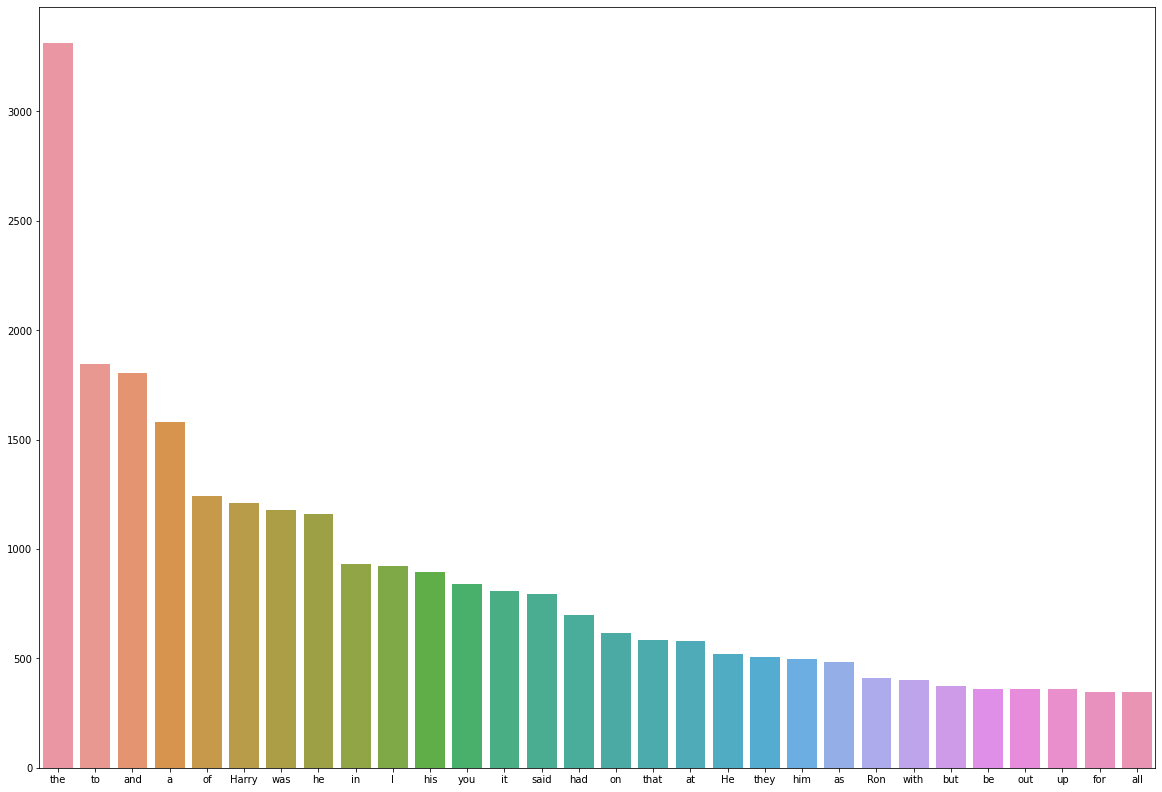

In [28]:
ax, fig = plt.subplots(1, figsize=(20, 14))
sns.barplot(x=[x[0] for x in most_common_words], y=[x[1] for x in most_common_words])

## We have 78301 words in the whole corpus

In [20]:
len(tokenized)

78298

In [21]:
tokenized[0:2]

['Mr', 'and']

In [28]:
def create_vectors(tokens, sequence_length:int) -> Tuple[List, str]:
    X, y = [], []
    
    for i in range(0, len(tokens) - sequence_length - 1):
        seq, word = tokens[i:i+sequence_length], tokens[i + sequence_length]
        X.append(' '.join(seq))
        y.append(word)
        
    return X, y

In [29]:
SEQ_LEN = 20

In [30]:
X, y = create_vectors(tokenized, SEQ_LEN)

In [31]:
X[0]

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you'

In [32]:
X[1]

'and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you very'

In [33]:
y[0]

'very'

In [34]:
len(X)

78277

In [29]:
from tensorflow import string as tf_string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [36]:
embedding_dim = 50 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
vocab_size = 7000 # Number of unique tokens in vocabulary
sequence_length = SEQ_LEN # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(standardize=None, max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X)

# Final step is integer encoding of the target words into numbers according to the defined vocabulary

In [37]:
vect_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'Harry', 'was', 'he']

In [38]:
vocab = vect_layer.get_vocabulary()

In [39]:
dict_vocab = {vocab[i]: i  for i in range(len(vocab))}

In [40]:
len(vect_layer.get_vocabulary())

6833

In [41]:
vocabulary_size = len(vect_layer.get_vocabulary())

In [42]:
y_enc = [dict_vocab[x] for x in y]

In [30]:
from tensorflow.compat.v1.keras.layers import CuDNNGRU, CuDNNLSTM
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_enc, test_size=0.2, random_state=13)

# We can define our model and train it using created sequences

In [45]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = LSTM(512, return_sequences=True)(emb)
x = LSTM(256, return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(vocabulary_size, activation=tf.nn.softmax)(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 20)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 20, 50)            350000    
                                                                 
 lstm (LSTM)                 (None, 20, 512)           1153024   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                             

In [46]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=700, restore_best_weights=True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
epochs = 5
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es, model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/5
490/490 [==============================] - 31s 47ms/step - loss: 6.8984 - accuracy: 0.0414 - val_loss: 6.7504 - val_accuracy: 0.0432
Epoch 2/5
490/490 [==============================] - 21s 44ms/step - loss: 6.6424 - accuracy: 0.0436 - val_loss: 6.7289 - val_accuracy: 0.0462
Epoch 3/5
490/490 [==============================] - 22s 45ms/step - loss: 6.4806 - accuracy: 0.0500 - val_loss: 6.5418 - val_accuracy: 0.0545
Epoch 4/5
490/490 [==============================] - 22s 45ms/step - loss: 6.3643 - accuracy: 0.0557 - val_loss: 6.4521 - val_accuracy: 0.0586
Epoch 5/5
490/490 [==============================] - 22s 46ms/step - loss: 6.3039 - accuracy: 0.0604 - val_loss: 6.4395 - val_accuracy: 0.0612


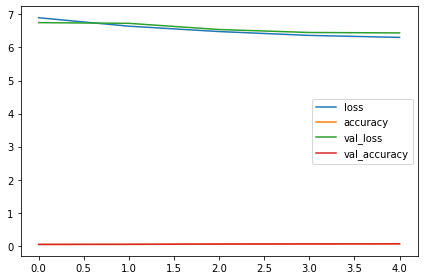

In [47]:
show_history(history)

In [48]:
X[0]

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you'

In [49]:
model.load_weights("weights.best.tf")

In [50]:
y_pred = model.predict([X[0]])

## Softmax gives you the probabilities which sums to 1 for every word in vocabulary
We need to to choose the word with the highest probability.

In [51]:
y_pred

array([[4.6187042e-06, 4.5612132e-06, 1.9495074e-02, ..., 7.0141355e-06,
        4.5571346e-06, 8.1847529e-06]], dtype=float32)

In [52]:
y_pred = np.argmax(y_pred[0])

In [53]:
y_pred

8

In [54]:
vocab[y_pred]

'was'

#### We won't use probabilities directly but we will sample from the predicted outputs using Temperature Softmax [see this](https://medium.com/@majid.ghafouri/why-should-we-use-temperature-in-softmax-3709f4e0161)

Basically, its ideas is that it would re-weight the probability distribution so that you can control how much surprising (i.e. higher temperature/entropy) or predictable (i.e. lower temperature/entropy) the next selected character would be.

In [31]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

We have to first generate a 20 vocab long sentence called seed text, then our model will use seed text to predict the next vocab, then we update the seed text with our newly generated vocab to predict the next vocab. Repeat this process to generate new text content.

In [56]:
paragraph = X[0]
whole_text = paragraph
for i in range(50):
    y_pred = model.predict([paragraph])
    y_pred = sample(y_pred[0], 10)
    word = vocab[y_pred]
    paragraph += f' {word}'
    whole_text += f' {word}'
    tokens = paragraph.split()
    paragraph = ' '.join(tokens[-SEQ_LEN:])

In [57]:
X[0]

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you'

In [58]:
whole_text

"Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you quivering Pretend dashed wrinkled bullied if sense Jigger pineapple tawny half sweater emptying informed recorded member ghosts icicles he lake Powerful hatches hovered chipolatas bent restaurant nearer Majorca Goshawk eyed holding defeat nudged smoother Knows feels nearby string Hedwig payin touches numbly shinin few sheer dwell pig's fly bending ward"

# We can even use pre-trained embedding

# We need to download the embedding files
~~~
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
~~~

50 dims GLOVE is also avaiable here: https://vsb.ai/downloads/glove.6B.50d.txt

In [60]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-16 10:16:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-16 10:16:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-16 10:16:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [61]:
!unzip -q glove.6B.zip

# First we need to load the file to memory and create embedding dictionary

In [63]:
path_to_glove_file = 'glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


## We need to get the voacabulary from the Vectorizer and the integer indexes

In [64]:
embedding_dim = 50 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
vocab_size = 7000 # Number of unique tokens in vocabulary
sequence_length = SEQ_LEN # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(standardize=None, max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X)

In [65]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [66]:
len(voc)

6833

In [67]:
voc[:10]

['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'Harry', 'was', 'he']

In [68]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 5152 words (1681 misses)


In [69]:
show_historyyer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=True)(x_v)
x = LSTM(128, return_sequences=True)(emb)
x = LSTM(128, return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.5)(x)
output_layer = keras.layers.Dense(vocabulary_size, activation=tf.nn.softmax)(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 20)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 20, 50)            341750    
                                                                 
 lstm_2 (LSTM)               (None, 20, 128)           91648     
                                                                 
 lstm_3 (LSTM)               (None, 20, 128)           131584    
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                           

#### Let's try to train the model for much longer time

In [70]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=700, restore_best_weights=True)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights2.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
# epochs = 50
epochs = 5

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es, model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/5
490/490 [==============================] - 21s 34ms/step - loss: 6.9738 - accuracy: 0.0402 - val_loss: 6.8034 - val_accuracy: 0.0432
Epoch 2/5
490/490 [==============================] - 14s 29ms/step - loss: 6.7167 - accuracy: 0.0421 - val_loss: 6.7326 - val_accuracy: 0.0432
Epoch 3/5
490/490 [==============================] - 13s 26ms/step - loss: 6.6343 - accuracy: 0.0427 - val_loss: 6.6810 - val_accuracy: 0.0445
Epoch 4/5
490/490 [==============================] - 13s 26ms/step - loss: 6.5324 - accuracy: 0.0461 - val_loss: 6.6476 - val_accuracy: 0.0491
Epoch 5/5
490/490 [==============================] - 12s 25ms/step - loss: 6.4226 - accuracy: 0.0533 - val_loss: 6.5739 - val_accuracy: 0.0603


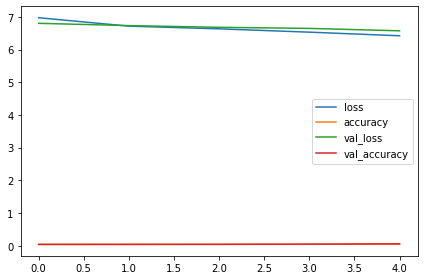

In [71]:
show_history(history)

In [72]:
model.load_weights("weights2.best.tf")

In [73]:
paragraph = X[0]
whole_text = paragraph
for i in range(50):
    y_pred = model.predict([paragraph])
    y_pred = sample(y_pred[0], 1)
    word = vocab[y_pred]
    paragraph += f' {word}'
    whole_text += f' {word}'
    tokens = paragraph.split()
    paragraph = ' '.join(tokens[-SEQ_LEN:])

In [74]:
X[0]

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you'

In [75]:
whole_text

'Mr and Mrs Dursley of number four Privet Drive were proud to say that they were perfectly normal thank you of happened he told they too over from a relief thing then could Hufflepuffs Harry Weasley none a nasty light Malfoy white face-to-face more table blood their feeling Emporium clutched Something sheared Harry think Uncle empty doing but his books the marks tried the not toppled keep that Let the'

# Your can see that we are able to generate text of any length using this approach, unfortunately the task is quite complex for model of this simplicity and relatively small dataset
## The text usually doesn't make much sense as you could see

# Another approach is to create character-level model which learns how to write from scratch
## We will try to train this model and comprare obtained results

#### We will simplify the task for using only lower case letters

In [76]:
txt_one_line = txt_one_line.lower()

In [77]:
txt_one_line[:100]

'mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly norma'

In [78]:
letters = []
for x in txt_one_line:
    if x >= 'a' and x <= 'z' or x == ' ':
        letters.append(x)

In [79]:
letters[:10]

['m', 'r', ' ', 'a', 'n', 'd', ' ', 'm', 'r', 's']

# We have corpus of 412 325 characters available

In [80]:
len(letters)

412325

In [81]:
chars = sorted(list(set(letters)))
print("Total chars:", len(chars))

Total chars: 27


In [82]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [83]:
char_indices

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

## We need to create fixed length sequences once again for prediction of the next character

In [84]:
SEQ_LEN = 40
step = 1
X, y = [], []
for i in range(0, len(letters) - SEQ_LEN, step):
    seq, ch = letters[i:i+SEQ_LEN], letters[i + SEQ_LEN]
    X.append(seq)
    y.append(ch)

In [85]:
X[0]

['m',
 'r',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'm',
 'r',
 's',
 ' ',
 'd',
 'u',
 'r',
 's',
 'l',
 'e',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 'n',
 'u',
 'm',
 'b',
 'e',
 'r',
 ' ',
 'f',
 'o',
 'u',
 'r',
 ' ',
 'p',
 'r',
 'i',
 'v',
 'e',
 't']

In [86]:
X[1]

['r',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'm',
 'r',
 's',
 ' ',
 'd',
 'u',
 'r',
 's',
 'l',
 'e',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 'n',
 'u',
 'm',
 'b',
 'e',
 'r',
 ' ',
 'f',
 'o',
 'u',
 'r',
 ' ',
 'p',
 'r',
 'i',
 'v',
 'e',
 't',
 ' ']

In [87]:
y[0]

' '

# OHE is used for the characted level RNN so we need to encode our characters

In [88]:
X_ohe = np.zeros((len(X), SEQ_LEN, len(chars)), dtype=np.bool)
y_ohe = np.zeros((len(X), len(chars)), dtype=np.bool)
for i, sentence in enumerate(X):
    for t, char in enumerate(sentence):
        X_ohe[i, t, char_indices[char]] = 1
    y_ohe[i, char_indices[y[i]]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [89]:
X_ohe[120]

array([[False, False, False, ..., False,  True, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [90]:
y_ohe[0]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [91]:
X_ohe.shape

(412285, 40, 27)

In [92]:
input_layer = keras.layers.Input(shape=(SEQ_LEN, len(chars)))
x = LSTM(128, return_sequences=True)(input_layer)
x = LSTM(128, return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(len(chars), activation=tf.nn.softmax)(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 27)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 40, 128)           79872     
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0   

In [93]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=700, restore_best_weights=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights3.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
epochs = 10

history = model.fit(X_ohe, y_ohe, validation_split=0.2, callbacks=[es, model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/10
2577/2577 [==============================] - 84s 31ms/step - loss: 2.0799 - accuracy: 0.3780 - val_loss: 1.7191 - val_accuracy: 0.4746
Epoch 2/10
2577/2577 [==============================] - 77s 30ms/step - loss: 1.6330 - accuracy: 0.4979 - val_loss: 1.5318 - val_accuracy: 0.5258
Epoch 3/10
2577/2577 [==============================] - 78s 30ms/step - loss: 1.5011 - accuracy: 0.5356 - val_loss: 1.4808 - val_accuracy: 0.5414
Epoch 4/10
2577/2577 [==============================] - 72s 28ms/step - loss: 1.4453 - accuracy: 0.5512 - val_loss: 1.4595 - val_accuracy: 0.5510
Epoch 5/10
2577/2577 [==============================] - 74s 29ms/step - loss: 1.4232 - accuracy: 0.5595 - val_loss: 1.4591 - val_accuracy: 0.5607
Epoch 6/10
2577/2577 [==============================] - 80s 31ms/step - loss: 1.4186 - accuracy: 0.5618 - val_loss: 1.4544 - val_accuracy: 0.5578
Epoch 7/10
2577/2577 [==============================] - 76s 30ms/step - loss: 1.4193 - accuracy: 0.5620 - val_loss: 1.4749 -

In [94]:
model.load_weights("weights3.best.tf")

In [95]:
X_ohe[0].reshape((1, 40, 27))

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [96]:
y_pred = model.predict(X_ohe[0].reshape((1, 40, 27)))[0]

In [97]:
y_pred

array([8.54093730e-01, 7.30780812e-06, 6.24281737e-10, 2.90388061e-06,
       2.51714466e-03, 5.96267986e-04, 1.33995659e-08, 1.56591375e-06,
       1.46608116e-07, 7.50979088e-05, 4.32939753e-29, 3.22474003e-09,
       2.81318818e-04, 1.21030580e-05, 8.05896940e-04, 1.82325439e-05,
       1.39811206e-07, 1.63061627e-28, 2.21348149e-04, 1.40589669e-01,
       7.76872039e-04, 1.04741185e-08, 6.08704059e-12, 5.23015808e-09,
       1.02179350e-26, 2.31094333e-07, 1.93971430e-23], dtype=float32)

In [98]:
c = sample(y_pred)
indices_char[c]

' '

In [101]:
whole_text = X[10].copy()
seq = X[10].copy()
for i in range(500):
    paragraph_ohe = np.zeros((1, SEQ_LEN, len(chars)))
    for t, char in enumerate(seq):
        paragraph_ohe[0, t, char_indices[char]] = 1
    y_pred = model.predict(paragraph_ohe)
    c = sample(y_pred[0], 0.5)
    next_char = indices_char[c]
    whole_text.append(next_char)
    seq = whole_text[-SEQ_LEN:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [102]:
''.join(whole_text)

' dursley of number four privet drive were in the sorting to into the directly no wood ginghard and he was something  of etwers some mong and hed had been haar wood on the borger the walk off in the thing the thing blank it around the wants harry badged and whievery seemed to year harry how why should the with a twing the class and her  and the first in under the ground and wa heads in the star and they went looked mofficn he had been bittercide behind the ways the fool his back him the said harry in the leam to not except dark the cor'

# Task for the lecture
 - Choose either word or character level model
 - Choose another, at least one, HP book (it's on my Github, link at the top)
 - Preprocess it according to the first one
 - Merge the books together
 - Use pre-defined model from lecture or your own and train it for the long time (epochs > 50)
 - Experiment a little - try different batch sizes, optimimizers
 - Show me the Colab notebook with results and description of what you did and your final solution during the next lecture

Porovnat texty po ruznem poctu epoch

In [32]:
#First book
txt_one_line[0:10]
print(len(txt_one_line))

430753


In [33]:
req2 = requests.get('https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/datasets/hp2.txt', allow_redirects=True)

In [34]:
txt2 = str(req2.text).splitlines()

txt2 = [x for x in txt2 if 'CHAPTER ' not in x]
txt2 = [x for x in txt2 if not x.upper() == x]
txt2 = [x.replace('"', '') for x in txt2]
txt_one_line_2 = ' '.join(txt2)

In [35]:
#Second book
txt_one_line_2[0:1000]
print(len(txt_one_line_2))

481268


In [36]:
merged = txt_one_line + txt_one_line_2
print(len(merged))

912021


In [37]:
merged = merged.lower()

letters = []
for x in merged:
    if x >= 'a' and x <= 'z' or x == ' ':
        letters.append(x)

In [38]:
len(letters)

874013

In [39]:
chars = sorted(list(set(letters)))
print("Total chars:", len(chars))

Total chars: 27


In [40]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [41]:
SEQ_LEN = 60
GENERATE_NUMBER_OF_CHARS = 2000

In [42]:
step = 1
X, y = [], []
for i in range(0, len(letters) - SEQ_LEN, step):
    seq, ch = letters[i:i+SEQ_LEN], letters[i + SEQ_LEN]
    X.append(seq)
    y.append(ch)

In [43]:
"".join(X[0])

'mr and mrs dursley of number four privet drive were proud to'

In [44]:
y[0]

' '

In [45]:
X_ohe = np.zeros((len(X), SEQ_LEN, len(chars)), dtype=np.bool)
y_ohe = np.zeros((len(X), len(chars)), dtype=np.bool)
for i, sentence in enumerate(X):
    for t, char in enumerate(sentence):
        X_ohe[i, t, char_indices[char]] = 1
    y_ohe[i, char_indices[y[i]]] = 1

/tmp/ipykernel_12096/3613875084.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_ohe = np.zeros((len(X), SEQ_LEN, len(chars)), dtype=np.bool)
/tmp/ipykernel_12096/3613875084.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_ohe = np.zeros((len(X), len(chars)), dtype=np.bool)


In [46]:
# input_layer = keras.layers.Input(shape=(SEQ_LEN, len(chars)))
# x = LSTM(128, return_sequences=True)(input_layer)
# x = LSTM(128, return_sequences=False)(x)
# x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(256, 'relu')(x)
# x = keras.layers.BatchNormalization(x)
# x = keras.layers.Dense(128, 'relu')(x)
# x = keras.layers.Dropout(0.2)(x)
# output_layer = keras.layers.Dense(len(chars), activation=tf.nn.softmax)(x)

# model = keras.Model(input_layer, output_layer)
# model.summary()

# model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=700, restore_best_weights=True)

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath='weights3.best.tf',
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='auto',
#     save_best_only=True)



# history = model.fit(X_ohe, y_ohe, validation_split=0.2, callbacks=[es, model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

In [47]:
# model.load_weights("weights3.best.tf")

In [48]:
# whole_text = X[10].copy()

In [49]:
# "".join(whole_text)

In [50]:
# for i in range(GENERATE_NUMBER_OF_CHARS):
#     paragraph_ohe = np.zeros((1, SEQ_LEN, len(chars)))
#     for t, char in enumerate(seq):
#         paragraph_ohe[0, t, char_indices[char]] = 1
#     y_pred = model.predict(paragraph_ohe)
#     c = sample(y_pred[0], 0.5)
#     next_char = indices_char[c]
#     whole_text.append(next_char)
#     seq = whole_text[-SEQ_LEN:]

In [52]:
TEST_EPOCHS = [
  10,
  20,
  30,
  40,
  50
]

OPTIMIZERS = [
'adam',
'rmsprop'
]

batch_size = 256

In [53]:
import time

In [54]:
res = {}

In [ ]:
counter = 0
for optimizer in OPTIMIZERS:
    for i, epochs in enumerate(TEST_EPOCHS):
        toc = time.time()

        print(f"{counter} - {optimizer} - {epochs}")

        input_layer = keras.layers.Input(shape=(SEQ_LEN, len(chars)))
        x = LSTM(128, return_sequences=True)(input_layer)
        x = LSTM(128, return_sequences=False)(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(256, 'relu')(x)
        x = keras.layers.Dense(128, 'relu')(x)
        x = keras.layers.Dropout(0.2)(x)
        output_layer = keras.layers.Dense(len(chars), activation=tf.nn.softmax)(x)

        model = keras.Model(input_layer, output_layer)
        model.summary()

        model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

        es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True)

        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='weights3.best.tf',
            save_weights_only=True,
            monitor='val_loss',
            mode='auto',
            save_best_only=True)



        history = model.fit(X_ohe, y_ohe, validation_split=0.2, callbacks=[es, model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

        model.load_weights("weights3.best.tf")

        whole_text = X[10].copy()

        for i in range(GENERATE_NUMBER_OF_CHARS):
            paragraph_ohe = np.zeros((1, SEQ_LEN, len(chars)))
            for t, char in enumerate(seq):
                paragraph_ohe[0, t, char_indices[char]] = 1
            y_pred = model.predict(paragraph_ohe)
            c = sample(y_pred[0], 0.5)
            next_char = indices_char[c]
            whole_text.append(next_char)
            seq = whole_text[-SEQ_LEN:]

        tic = time.time()

        res[counter] = {
            "generated_text": whole_text,
            "epochs": epochs,
            "generated_chars": GENERATE_NUMBER_OF_CHARS,
            "seq_len": SEQ_LEN,
            "batch_size": batch_size,
            "time_run": tic - toc,
            "optimizer": optimizer
        }

        counter += 1 

0 - adam - 10


2022-03-20 18:07:01.139314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-20 18:07:01.139347: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-20 18:07:01.139829: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 27)]          0         
                                                                 
 lstm (LSTM)                 (None, 60, 128)           79872     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0     

/tmp/ipykernel_12096/913138547.py:4: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


1 - adam - 20
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 27)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 128)           79872     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)     

2732/2732 [==============================] - 914s 335ms/step - loss: 1.1330 - accuracy: 0.6352 - val_loss: 1.2555 - val_accuracy: 0.6148
Epoch 17/30
2732/2732 [==============================] - 845s 309ms/step - loss: 1.1248 - accuracy: 0.6378 - val_loss: 1.2619 - val_accuracy: 0.6144
Epoch 18/30
2732/2732 [==============================] - 850s 311ms/step - loss: 1.1177 - accuracy: 0.6402 - val_loss: 1.2612 - val_accuracy: 0.6166
Epoch 19/30
2732/2732 [==============================] - 908s 332ms/step - loss: 1.1108 - accuracy: 0.6418 - val_loss: 1.2637 - val_accuracy: 0.6139
Epoch 20/30
2732/2732 [==============================] - 903s 331ms/step - loss: 1.1031 - accuracy: 0.6437 - val_loss: 1.2750 - val_accuracy: 0.6156
Epoch 21/30
2732/2732 [==============================] - 847s 310ms/step - loss: 1.0969 - accuracy: 0.6455 - val_loss: 1.2724 - val_accuracy: 0.6159
Epoch 22/30
2732/2732 [==============================] - 847s 310ms/step - loss: 1.0903 - accuracy: 0.6471 - val_loss:

In [63]:
df

,generated_text,epochs,generated_chars,seq_len,batch_size,time_run,optimizer
0,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",10,2000,60,256,8731.709074,adam
1,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",20,2000,60,256,20538.951594,adam
2,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",30,2000,60,256,29551.615134,adam
3,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",40,2000,60,256,34871.355740,adam
4,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",50,2000,60,256,35776.481059,adam
5,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",10,2000,60,256,10757.317433,rmsprop
6,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",20,2000,60,256,21745.829852,rmsprop
7,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",30,2000,60,256,30520.307349,rmsprop
8,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",40,2000,60,256,25887.351698,rmsprop
9,"[ , d, u, r, s, l, e, y, , o, f, , n, u, m, ...",50,2000,60,256,23387.064028,rmsprop


In [64]:
df = pd.DataFrame.from_dict(res, orient="index")

In [67]:
df['generated_text'] =  list(map(lambda x: "".join(x), df['generated_text'].values))

In [75]:
for i in range(df.shape[0]):
    epochs = df['epochs'].values
    optimizers = df['optimizer'].values
    texts = df['generated_text'].values
    
    print(f"Epoch: {epochs[i]}")
    print(f"Optimizer: {optimizers[i]}")
    print(f"Text: {texts[i]}")
    print("\n")

Epoch: 10
Optimizer: adam
Text:  dursley of number four privet drive were proud to say that  the reason of the corner to his forehead he couldnt see him off he was seen anything harry said he looked quickly suddenly he said mr weasley had happened out a put he stopped out of the stone hagrid was do you see how could they know and he reached the stadium he was fan do the stone stuff that all the troll said harry they had never been a treating straight behind him he had seen he was trying to with the dark school the dursleys the rest of the boy from the common stretched at the neck in the son who was wearing the bedroom so the goal cold thing that the day of the ground the crowd the car were was on the toocre and was the gryffindor for you that the dark food the door was saying a stridick and no one ron said but he said and they started about more behind his trouble he had to get out of the start that silver we mean he said the good open back on the witch courage which were all about the

In [65]:
df.to_csv("results.csv")